# Transfer Learning

### importing necessary libraries

In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions,preprocess_input
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import backend as K



## Transfer Learning for Neural Networks

> Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis (japanese racoons).

__The benefits of transfer learning are:__
* you can reuse pre-trained networks
* it saves lots of training time
* it allows you to train with very small training datasets

__Procedure__
1. Take the weights and architecture of a [pre-trained network](https://keras.io/api/applications/)
2. Load the "convolutional base" of the model (everything except the final dense layers)
3. Freeze all the layers of the base (weights become fixed)
4. Add a fully connected dense layer on top
5. **Add a task specific dense output layer**
6. Compile and fit the model to your data

## Load images into `keras`
Keras has its own in build Objects and Methods to get image data in efficiently
See: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

- `class ImageDataGenerator`: Generate batches of tensor image data with **optional** real-time data augmentation

In [2]:
# folder names containing images of the things you want to classify
classes = ['10_cent', '1_euro', '20_cent', '2_cent', '2_euro', '50_cent', '5_cent', 'empty']
# plug in the path to your data folder
train_base_path = 'data_2/train/'
test_base_path = 'data_2/test/'

In [3]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
     #rotation_range=20,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     #horizontal_flip=True, 
     #vertical_flip=True,
    # zoom_range=0.2,
     shear_range=0.2    
)

In [4]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=train_base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224)
)

Found 7364 images belonging to 8 classes.


In [5]:
# a generator that returns batches of X and y arrays
test_data_gen = data_gen.flow_from_directory(
        directory=test_base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224)
)

Found 752 images belonging to 8 classes.


In [6]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((30, 224, 224, 3), (30, 8))

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(6, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

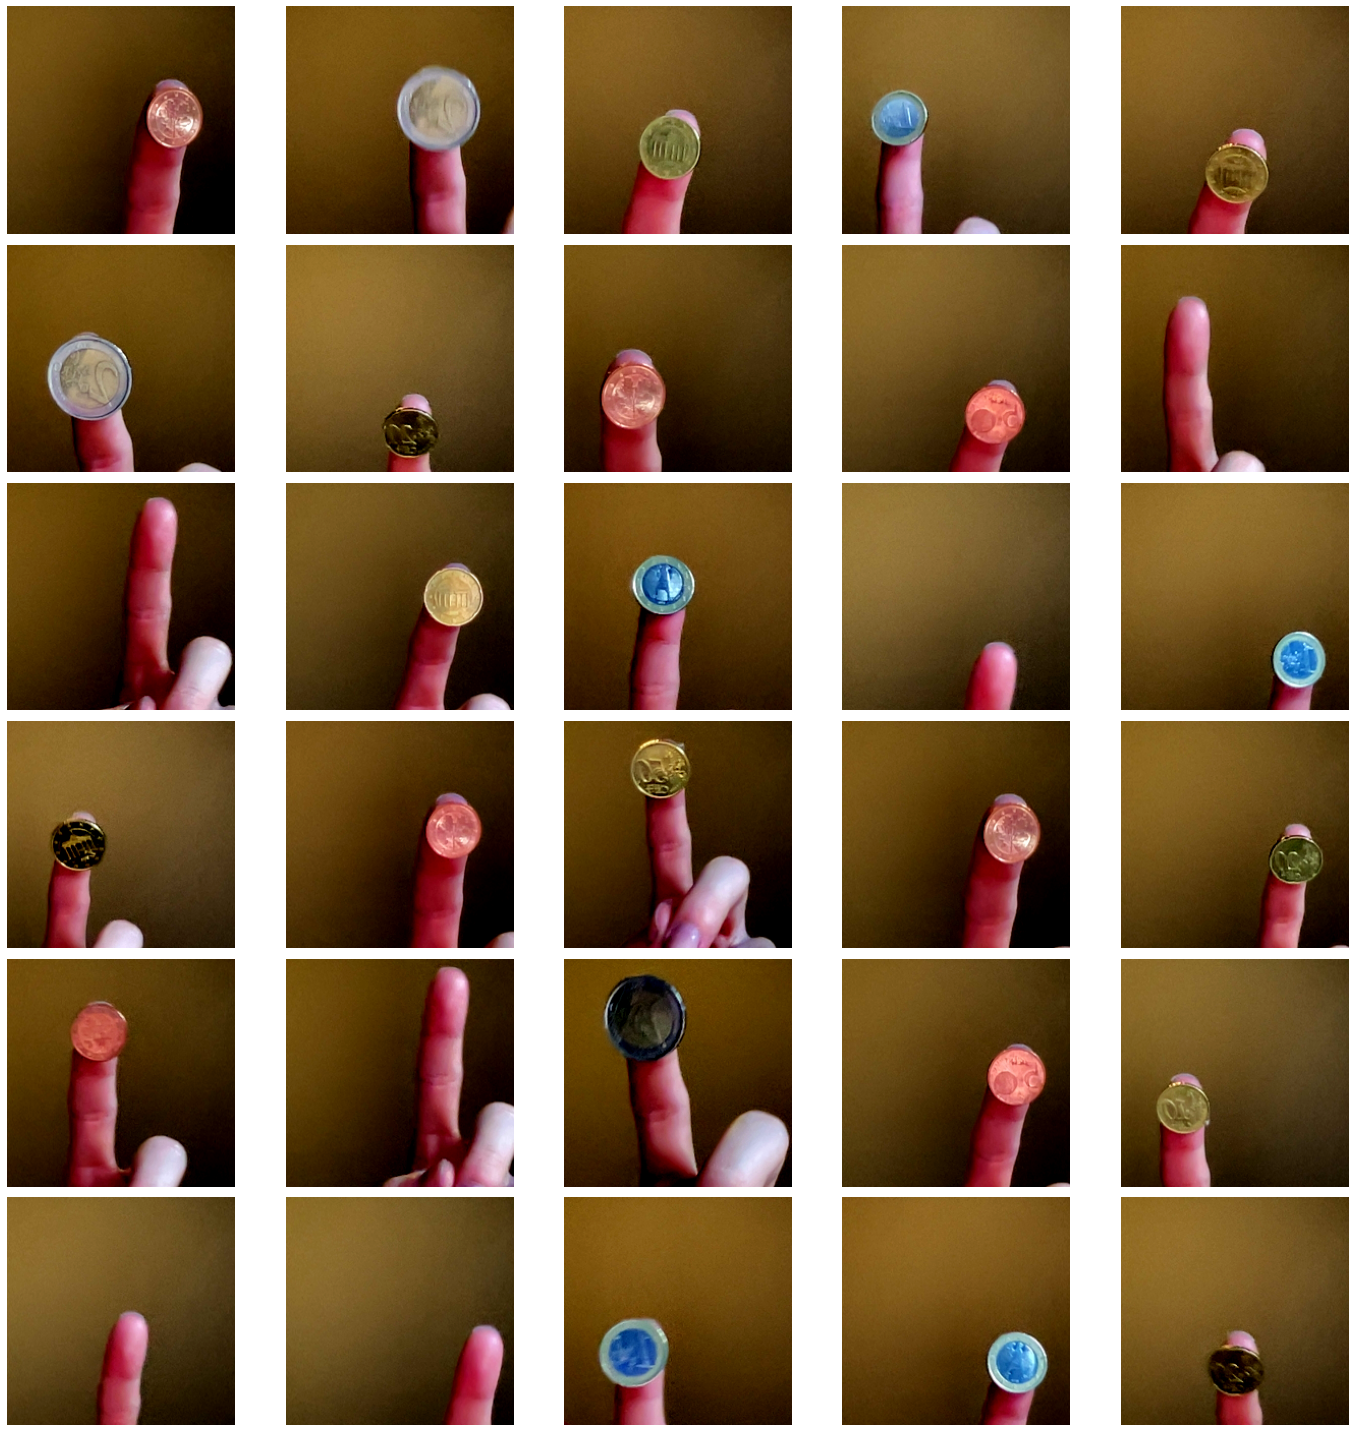

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [8]:
plotImages(xtrain)
print(ytrain)

In [9]:
classes

['10_cent',
 '1_euro',
 '20_cent',
 '2_cent',
 '2_euro',
 '50_cent',
 '5_cent',
 'empty']

In [10]:
ytrain

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 

## Create CNN Model
### 1. Select the convolutional base 

In [11]:
K.clear_session()
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)



# base_model = ResNet50(
#     weights='imagenet',
#     include_top=False, # remove the top dense layers
#     input_shape=(224,224,3),
#     pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix
# )

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-02-11 15:16:50.535113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-11 15:16:50.535795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

Alpha parameter : Controls the width of the network. This is known as the width multiplier in the MobileNet paper. - If alpha < 1.0, proportionally decreases the number of filters in each layer. - If alpha > 1.0, proportionally increases the number of filters in each layer. - If alpha = 1, default number of filters from the paper are used at each layer. Default to 1.0.


### 2. Freeze the weights

In [13]:
# freeze it!
base_model.trainable = False

### 3. Add your own dense layers on top

In [14]:
len(classes)

8

In [15]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

In [16]:
model = keras.Sequential()
model.add(base_model)
#custom dense layer


model.add(keras.layers.Dense(80, activation='relu'))
model.add(keras.layers.Dense(80, activation='relu'))
model.add(keras.layers.Dense(80, activation='relu'))


model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

#(30, 224, 224, 3), (30, 8))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense (Dense)               (None, 80)                102480    
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 648       
                                                        

### 4. Compile and train!

In [17]:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
#               loss=keras.losses.categorical_crossentropy,
#               metrics=[keras.metrics.categorical_accuracy])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',\
metrics=['accuracy'])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.2)

Epoch 1/50


2022-02-11 15:16:51.590300: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-11 15:16:52.201604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-11 15:16:53.319368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 - 2s - loss: 2.2798 - accuracy: 0.0833 - val_loss: 1.9448 - val_accuracy: 0.1667 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 2.0824 - accuracy: 0.2083 - val_loss: 1.9282 - val_accuracy: 0.5000 - 123ms/epoch - 123ms/step
Epoch 3/50
1/1 - 0s - loss: 2.0604 - accuracy: 0.1667 - val_loss: 1.9363 - val_accuracy: 0.5000 - 71ms/epoch - 71ms/step
Epoch 4/50
1/1 - 0s - loss: 2.0076 - accuracy: 0.3333 - val_loss: 1.9211 - val_accuracy: 0.6667 - 76ms/epoch - 76ms/step
Epoch 5/50
1/1 - 0s - loss: 1.8794 - accuracy: 0.4583 - val_loss: 1.8884 - val_accuracy: 0.6667 - 77ms/epoch - 77ms/step
Epoch 6/50
1/1 - 0s - loss: 1.7984 - accuracy: 0.4167 - val_loss: 1.8424 - val_accuracy: 0.6667 - 90ms/epoch - 90ms/step
Epoch 7/50
1/1 - 0s - loss: 1.8420 - accuracy: 0.4583 - val_loss: 1.7919 - val_accuracy: 0.5000 - 74ms/epoch - 74ms/step
Epoch 8/50
1/1 - 0s - loss: 1.6309 - accuracy: 0.6667 - val_loss: 1.7372 - val_accuracy: 0.5000 - 70ms/epoch - 70ms/step
Epoch 9/50
1/1 - 0s - loss: 1.5881 - accuracy

### (5. Use it to predict)

In [18]:
img = image.load_img('1_euro_test.png')

In [19]:
a = image.img_to_array(img, dtype = 'uint8')
a.shape

(224, 224, 3)

In [20]:
a = np.expand_dims(a, axis=0)
a.shape

(1, 224, 224, 3)

In [21]:
model.predict(a)

2022-02-11 15:16:58.125024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[1.0477875e-01, 9.2447437e-02, 7.8307563e-01, 3.9521266e-05,
        2.8155597e-03, 1.9805864e-03, 9.3421718e-04, 1.3928329e-02]],
      dtype=float32)

In [22]:
classes

['10_cent',
 '1_euro',
 '20_cent',
 '2_cent',
 '2_euro',
 '50_cent',
 '5_cent',
 'empty']

In [23]:
model.predict(a)[0].round(decimals = 3)

array([0.105, 0.092, 0.783, 0.   , 0.003, 0.002, 0.001, 0.014],
      dtype=float32)

In [24]:
classes

['10_cent',
 '1_euro',
 '20_cent',
 '2_cent',
 '2_euro',
 '50_cent',
 '5_cent',
 'empty']

<BarContainer object of 8 artists>

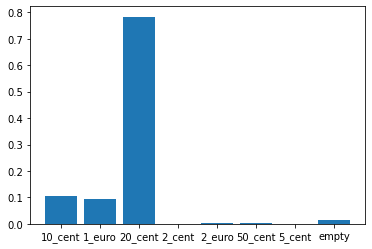

In [25]:
plt.bar(x = classes, height = model.predict(a)[0])

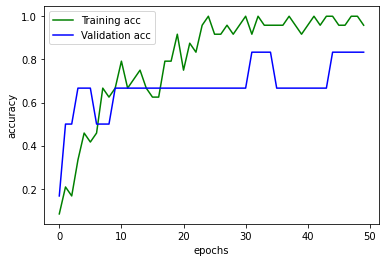

In [64]:
plt.plot(history.history['accuracy'], 'g', label='Training acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

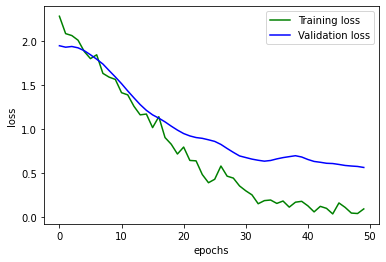

In [62]:
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [27]:
model.save('models/currency2.h5')

/Users/shoheisuzuki/miniforge3/envs/neuralnetwork/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [28]:
#confusion matrix


## Test data

In [29]:
# load in all images at once
xtest, ytest = next(test_data_gen)
xtrain.shape, ytrain.shape

((30, 224, 224, 3), (30, 8))

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(6, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

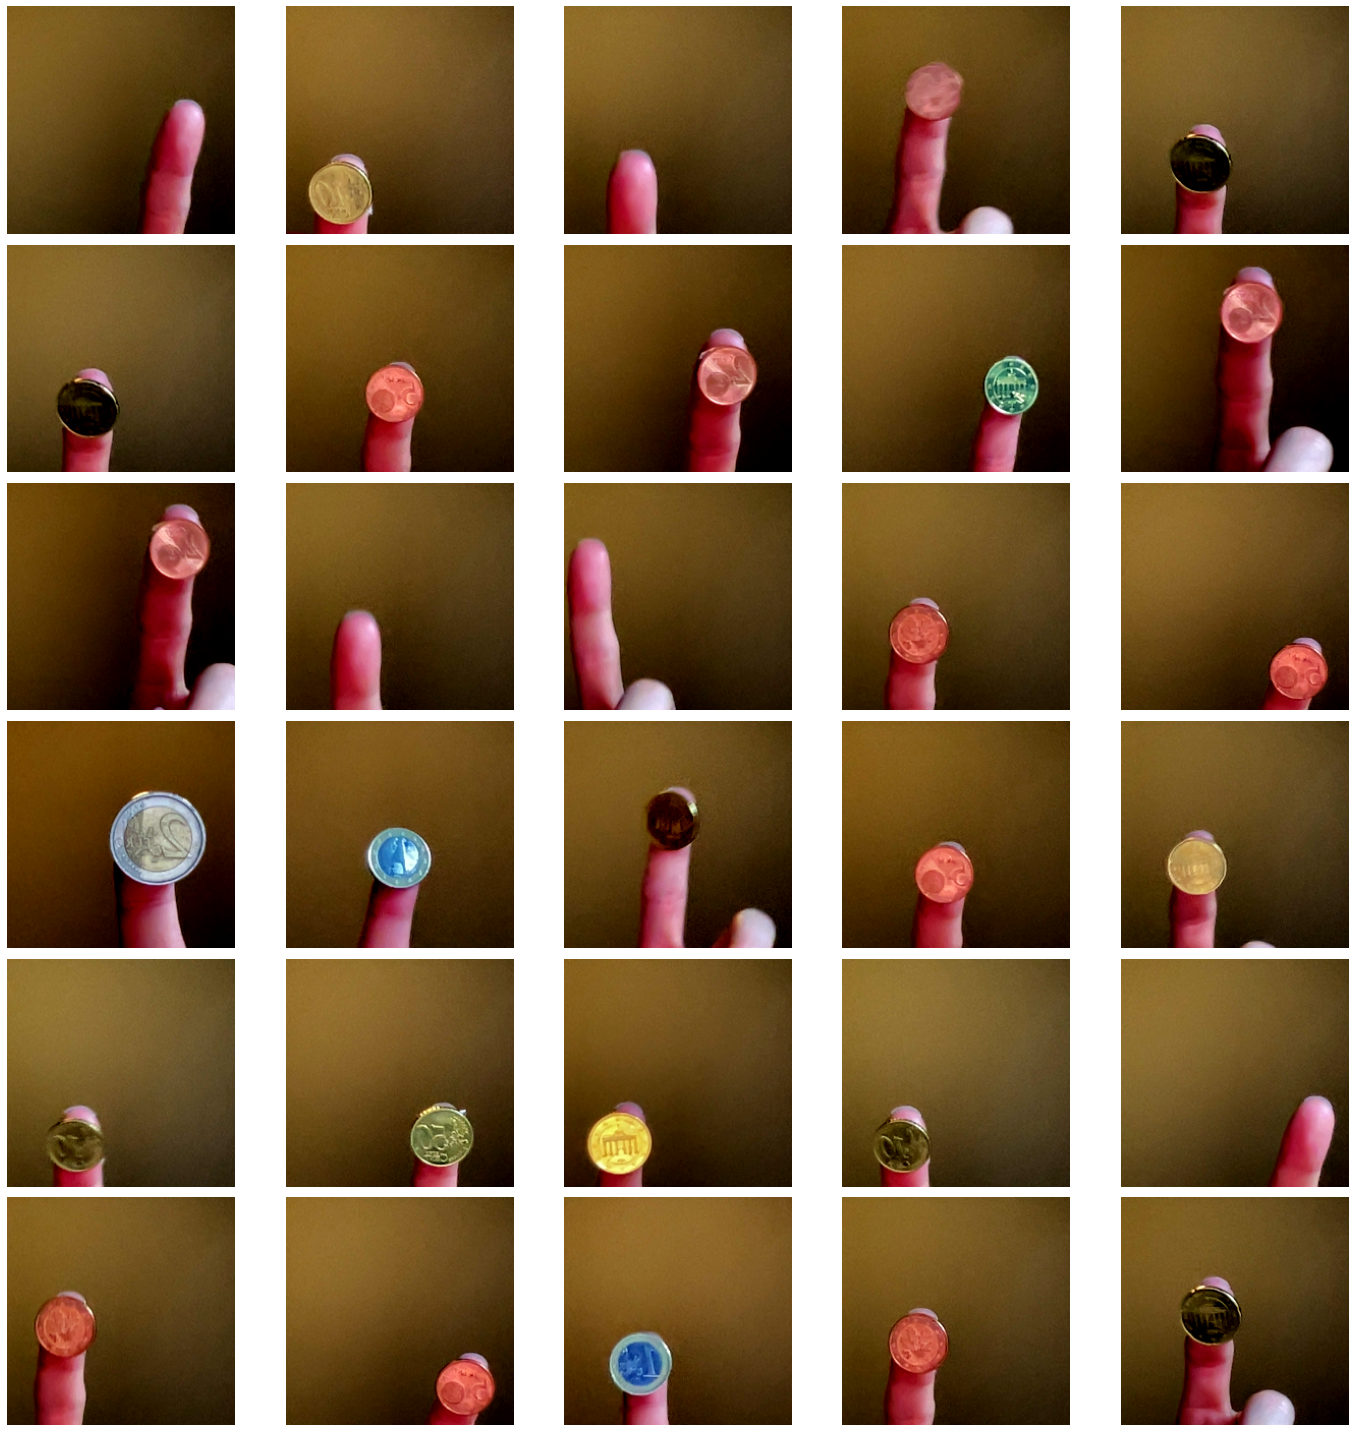

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [31]:
plotImages(xtest)
print(ytest)

In [32]:
pred = model.predict(xtest)

2022-02-11 15:17:01.415851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [33]:
pred

array([[1.7035472e-04, 3.8928698e-05, 8.0990256e-04, 3.2447711e-05,
        1.2193137e-03, 2.7996421e-04, 9.8770717e-05, 9.9735034e-01],
       [1.9620347e-01, 8.8151069e-03, 2.6936042e-01, 1.1096896e-04,
        4.9327692e-01, 2.4367520e-03, 7.3839012e-03, 2.2412555e-02],
       [2.1526837e-04, 7.5805743e-05, 3.5788017e-04, 1.9177240e-05,
        1.1239644e-03, 1.6139531e-04, 3.1345623e-04, 9.9773318e-01],
       [5.5293411e-02, 1.1234841e-02, 1.1883534e-02, 9.0070884e-04,
        1.7184982e-01, 1.8694066e-02, 5.3397882e-01, 1.9616480e-01],
       [6.2974882e-01, 1.1324628e-02, 3.3808923e-01, 6.9061422e-04,
        5.6735449e-03, 5.6863558e-03, 2.2136762e-03, 6.5731229e-03],
       [8.8241976e-01, 1.9546654e-02, 6.6583633e-02, 9.6451392e-04,
        7.2168573e-03, 1.4193681e-02, 4.1370527e-03, 4.9378844e-03],
       [2.2250984e-02, 7.0318901e-03, 5.0066679e-04, 3.6612891e-03,
        8.6693754e-03, 2.4970106e-03, 9.5402271e-01, 1.3661042e-03],
       [6.5034661e-03, 1.3341540e-03, 7.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


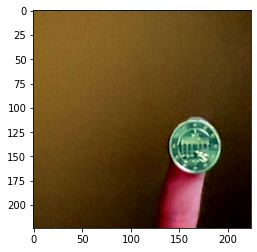

In [34]:
plt.imshow(xtest[8])

In [35]:
ytest_true = ytest.copy()

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2022-02-11 15:17:02.457302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[ 5  9  8  3  8  2 10  5]
 [10 10 13 12 19  6 16 15]
 [ 7 12 21 20 17  1  9 13]
 [ 7  8 20  8 17  8 16 17]
 [ 8 16 21 11  8  7 16 13]
 [ 6 15 20  8 10  7 18 16]
 [ 5 16 22  7 19  4 13 14]
 [ 5 18 25  9 20  1  9 13]]


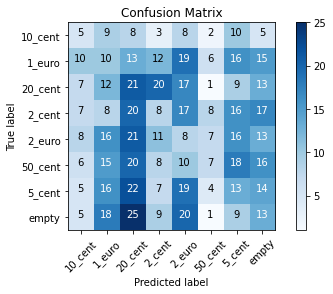

In [37]:
# plt.figure(figsize = (8,8))

# pred = model.predict(xtest)
# cm = confusion_matrix(y_true=ytest_true, y_pred=np.argmax(pred, axis=1))

# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                              display_labels=np.unique(ytest_true))
# disp.plot()

predictions = model.predict(x=test_data_gen, verbose=0)
cm = confusion_matrix(y_true=test_data_gen.classes,
                      y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ['10_cent', '1_euro', '20_cent', '2_cent', '2_euro', '50_cent', '5_cent', 'empty']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


# predictions = model.predict(x=test_batches, verbose=0)
# cm = confusion_matrix(y_true=test_batches.classes, \
#                       y_pred=np.argmax(predictions, axis=-1))

# cm_plot_labels = ['cat','dog']
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[ 55 124 225  86 138  53 152 122]
 [ 48 101 201  84 132  70 139 128]
 [ 66 125 199  87 129  48 131 122]
 [ 52 134 215  96 122  49 155 129]
 [ 54 115 190  93 147  53 148 110]
 [ 48 117 205  85 152  56 150 100]
 [ 55 118 203  84 142  57 144 108]
 [ 34 126 182  93 152  55 138 133]]


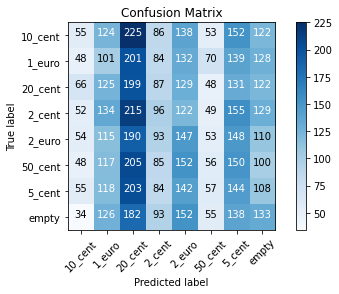

In [38]:
#train data
predictions = model.predict(x=train_data_gen, verbose=0)
cm = confusion_matrix(y_true=train_data_gen.classes,
                      y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ['10_cent', '1_euro', '20_cent', '2_cent', '2_euro', '50_cent', '5_cent', 'empty']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [39]:
# why ytest_true = ytest.copy()
# ResNet50

In [40]:
def TestImgPreprocessing(path):
    '''
    Resizes all images in a given file path to (224,224) and MinMax scales 
    Return array of images
    Adapted from https://stackoverflow.com/questions/21517879/
    python-pil-resize-all-images-in-a-folder
    '''
    from PIL import Image
    import os
    dirs = sorted(os.listdir(path))
    images = []
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize = np.asarray(imResize)/255
            images.append(imResize)
    return np.asarray(images)

test_imgs_1 = TestImgPreprocessing('data_2/test/1_euro/')
test_imgs_2 = TestImgPreprocessing('data_2/test/5_cent/')    

In [41]:
test_imgs_1

array([[[[0.76470588, 0.67843137, 0.54509804],
         [0.76470588, 0.67843137, 0.54509804],
         [0.76078431, 0.6745098 , 0.54117647],
         ...,
         [0.71764706, 0.64705882, 0.55294118],
         [0.70980392, 0.63529412, 0.54509804],
         [0.70980392, 0.63529412, 0.54509804]],

        [[0.76078431, 0.6745098 , 0.54117647],
         [0.76470588, 0.67843137, 0.54509804],
         [0.76078431, 0.6745098 , 0.54117647],
         ...,
         [0.71764706, 0.64705882, 0.54509804],
         [0.70588235, 0.63529412, 0.53333333],
         [0.70196078, 0.63137255, 0.52941176]],

        [[0.76078431, 0.6745098 , 0.54117647],
         [0.76078431, 0.6745098 , 0.54117647],
         [0.76470588, 0.67843137, 0.54509804],
         ...,
         [0.70196078, 0.63137255, 0.52941176],
         [0.70588235, 0.63529412, 0.53333333],
         [0.70588235, 0.63529412, 0.53333333]],

        ...,

        [[0.61960784, 0.56470588, 0.48235294],
         [0.61960784, 0.56470588, 0.48235294]

In [42]:
#Custom model test predictions (open downloaded images folder)
predictions = np.round(model.predict(test_imgs_1))
print(predictions)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 

In [43]:
!pip install lime

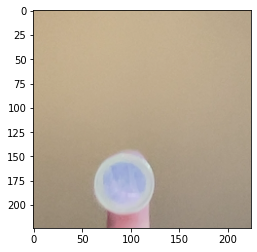

In [44]:
plt.imshow(test_imgs_1[5])

In [45]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively,
#if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_imgs_1[5], model.predict)

100%|██████████| 1000/1000 [00:06<00:00, 157.97it/s]


In [46]:
model.predict(test_imgs_1)[5]

array([1.3520443e-01, 4.8343375e-01, 1.8051859e-02, 3.8914222e-04,
       2.2544327e-01, 6.0757319e-03, 7.8223109e-02, 5.3178754e-02],
      dtype=float32)

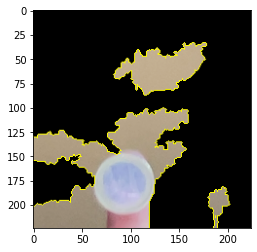

In [47]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
                            positive_only=True, num_features=8, hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))

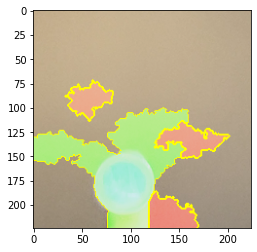

In [48]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
                            positive_only=False, num_features=8, hide_rest=False)

plt.imshow(mark_boundaries(temp, mask))

In [49]:
#Custom model test predictions (open downloaded images folder)
predictions = np.round(model.predict(test_imgs_2))
print(predictions)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 

In [50]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively,
#if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_imgs_2[50], model.predict)

100%|██████████| 1000/1000 [00:06<00:00, 145.96it/s]


In [51]:
model.predict(test_imgs_2)[50]

array([0.10049375, 0.06001168, 0.01273121, 0.01060711, 0.38734162,
       0.00706861, 0.40442276, 0.01732323], dtype=float32)

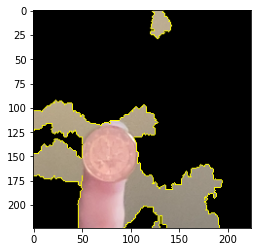

In [52]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
                            positive_only=True, num_features=10, hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))

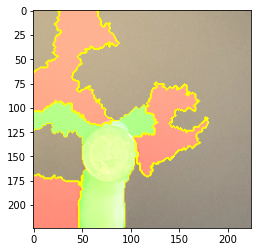

In [53]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
                            positive_only=False, num_features=10, hide_rest=False)

plt.imshow(mark_boundaries(temp, mask))


In [55]:
#Next
#Not using preprocessing because it might have currency category but not specific currency cateogries
#preprocessing images to identify the number on currencies and maybe color